# Transfer Learning
With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task. A good analogy for this is an artist who is skilled in one medium, such as painting, who wants to learn to practice in another medium, such as charcoal drawing. We can imagine that the skills they learned while painting would be very valuable in learning how to draw with charcoal.

As an example in deep learning, say we have a pre-trained model that is very good at recognizing different type of cars, and we want to train a model to recognize types of motorcycles. A lot of the learnings of the car model would likely be very useful, for instance the ability to recognize headlights and wheels.

Transfer learning is especially powerful when we don't have a large dataset.

The challenge is that the pre-trained model was not trained to recognize the specific dog, and we only have 30 pictures of Bo. If we trained a model from scratch using those 30 pictures we would experience overfitting and poor generalization. However, if we start with a pre-trained model that is adept at detecting dogs, we can leverage that learning to gain a generalized understanding of Bo using our smaller dataset.

<img src="data/presidential_dog/train/bo/bo_10.jpg">

In [3]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet', #Load weights pre-trained on ImageNet
    input_shape = (224,224,3),
    include_top=False,
)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Freezing the Base Model
Before adding our new layers, we should take an important step: freeing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead, we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset.If they were unfrozen at this stage, we would likely destroy this valuable information.

In [4]:
base_model.trainable = False

# Adding new Layers
We will add two layers to the model. First will be a pooling layer, and then we need to add our final layer, to classify Bo or not Bo, this will be a densely connected layer.

In [5]:
inputs = keras.Input(shape=(224,224,3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


# Compiling the Model
By setting `from_logits = True` we inform the loss function that the outputs values are not normalized (e.g. in softmax)

In [10]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits = True), metrics =[keras.metrics.BinaryAccuracy()])

# Augmenting the Data
Now that we are dealing with the very small dataset, it is especially important that we augment our data. As before, we will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new pictures of Bo instead of jut memorizing the pictured it trains on.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center = True,# set each sample mean to 0
    rotation_range = 10,# Rotates image in range (degrees, 0,180)
    zoom_range = 0.1,# Randomly zooms image
    width_shift_range = 0.1,# Randomly shifts the image horizontally
    height_shift_range = 0.1,# Randomly shifts the image vertically
    horizontal_flip = True,# Flips image horizontally
    vertical_flip = False,# Flips image vertically set to False
)

datagen_valid = ImageDataGenerator(samplewise_center=True)

# Loading the Data
We will load the data straight from the directory, we have train and validation directories.

In [14]:
# Load training data
train_it = datagen_train.flow_from_directory(
    "data/presidential_dog/train/",
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
)
#Load validation data
valid_it = datagen_valid.flow_from_directory(
    "data/presidential_dog/valid/",
    target_size=(224,244),
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


# Training the Model

In [15]:
model.fit(train_it,steps_per_epoch=12,validation_data=valid_it,validation_steps=4,epochs=20)

Epoch 1/20
12/12 [==============================] - 32s 2s/step - loss: 1.0002 - binary_accuracy: 0.7802 - val_loss: 1.2844 - val_binary_accuracy: 0.7333
Epoch 2/20
12/12 [==============================] - 25s 2s/step - loss: 0.7068 - binary_accuracy: 0.8242 - val_loss: 0.9937 - val_binary_accuracy: 0.7667
Epoch 3/20
12/12 [==============================] - 26s 2s/step - loss: 0.3187 - binary_accuracy: 0.8750 - val_loss: 0.6488 - val_binary_accuracy: 0.8667
Epoch 4/20
12/12 [==============================] - 24s 2s/step - loss: 0.3920 - binary_accuracy: 0.8901 - val_loss: 0.3577 - val_binary_accuracy: 0.9000
Epoch 5/20
12/12 [==============================] - 23s 2s/step - loss: 0.1123 - binary_accuracy: 0.9479 - val_loss: 0.2107 - val_binary_accuracy: 0.8667
Epoch 6/20
12/12 [==============================] - 22s 2s/step - loss: 0.1209 - binary_accuracy: 0.9670 - val_loss: 0.3465 - val_binary_accuracy: 0.9000
Epoch 7/20
12/12 [==============================] - 22s 2s/step - loss: 0.04

# Fine-Tuning the Model
Now that the new layers of the model are trained, we have the option to apply a final tick to improve the model.To do this we unfreeze the entire model, and train it again with very small learning rate.This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.



In [24]:
base_model.trainable = True

# It's important to recompile the model after you make any changes

model.compile(optimizer= keras.optimizers.RMSprop(learning_rate = .00001),
              loss= keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [keras.metrics.BinaryAccuracy()]
              )

In [25]:
model.fit(train_it,steps_per_epoch=12, validation_data=valid_it, validation_steps=4,epochs=10)

Epoch 1/10
12/12 [==============================] - 91s 6s/step - loss: 0.0510 - binary_accuracy: 0.9780 - val_loss: 0.0255 - val_binary_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 74s 6s/step - loss: 1.4997e-04 - binary_accuracy: 1.0000 - val_loss: 0.0192 - val_binary_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 74s 6s/step - loss: 2.4803e-04 - binary_accuracy: 1.0000 - val_loss: 0.0064 - val_binary_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 75s 6s/step - loss: 4.4690e-04 - binary_accuracy: 1.0000 - val_loss: 0.1539 - val_binary_accuracy: 0.9667
Epoch 5/10
12/12 [==============================] - 76s 6s/step - loss: 4.0689e-04 - binary_accuracy: 1.0000 - val_loss: 0.0048 - val_binary_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 88s 8s/step - loss: 1.8439e-05 - binary_accuracy: 1.0000 - val_loss: 0.0074 - val_binary_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 88s 

# Examining the Predictions

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)

def make_prediction(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224,224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    pred = model.predict(image)
    return pred

1/1 [==============================] - 1s 1s/step


array([[-6.259275]], dtype=float32)

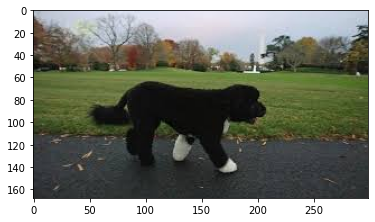

In [32]:
make_prediction('data/presidential_dog/valid/bo/bo_26.jpg')

1/1 [==============================] - 0s 292ms/step


array([[12.492048]], dtype=float32)

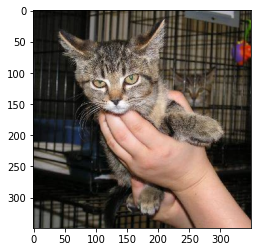

In [33]:
make_prediction('data/presidential_dog/valid/not_bo/135.jpg')

# Bo's Doggy Door

In [37]:
def presidential_dog(image_path):
    pred = make_prediction(image_path)
    if pred[0] <= 0:print("It's Bo! Let him in")
    else: print("That's not Bo! Stay out!")

1/1 [==============================] - 0s 203ms/step
That's not Bo! Stay out!


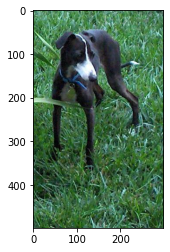

In [39]:
presidential_dog('data/presidential_dog/valid/not_bo/131.jpg')

1/1 [==============================] - 0s 253ms/step
It's Bo! Let him in


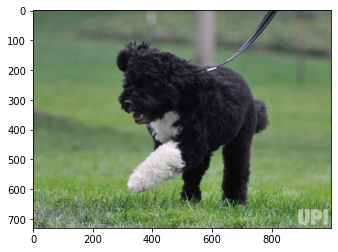

In [40]:
presidential_dog('data/presidential_dog/valid/bo/bo_29.jpg')